### Sales forecasting Model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
import multiprocessing as mp
from datetime import datetime
%matplotlib inline  

#pd.options.mode.use_inf_as_na = True

In [2]:
import pickle
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

Using TensorFlow backend.


#### Import the 10% sample data from merged csv file to merged_df dataframe with memory optimization

In [3]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32,
            "onpromotion":np.uint8,
            "Year":np.uint16,
            "Month":np.uint8,
            "Day":np.uint8,
            "transactions":np.uint16,
            "class":np.uint16,
            "perishable":np.uint8,
            "cluster":np.uint8,
            "dcoilwtico":np.float32
           }

merged_df = pd.read_csv('data/train_merged.csv', dtype=dtype_dict)

mem_train = merged_df.memory_usage(index=True).sum()
print("train dataset uses ",mem_train/ 1024**2," MB")

print(merged_df.dtypes)
merged_df.head()

train dataset uses  1267.1199111938477  MB
Unnamed: 0        int64
store_nbr         uint8
item_nbr         uint32
unit_sales      float32
onpromotion       uint8
Year             uint16
Month             uint8
Day               uint8
transactions     uint16
family           object
class            uint16
perishable        uint8
city             object
state            object
type_x           object
cluster           uint8
dcoilwtico      float32
type_y           object
locale           object
locale_name      object
description      object
transferred      object
dtype: object


,Unnamed: 0,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,...,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,7,464907,1.0,0,2016,6,15,1939,GROCERY I,...,Quito,Pichincha,D,8,47.919998,NaN,NaN,NaN,NaN,NaN
1,1,7,464907,1.0,0,2013,1,9,1525,GROCERY I,...,Quito,Pichincha,D,8,93.080002,NaN,NaN,NaN,NaN,NaN
2,2,7,464907,1.0,0,2016,6,19,1689,GROCERY I,...,Quito,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN
3,3,7,464907,1.0,0,2017,6,3,1994,GROCERY I,...,Quito,Pichincha,D,8,NaN,NaN,NaN,NaN,NaN,NaN
4,4,7,464907,1.0,0,2016,7,29,1874,GROCERY I,...,Quito,Pichincha,D,8,41.540001,NaN,NaN,NaN,NaN,NaN


In [4]:
merged_df.tail()

,Unnamed: 0,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,...,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
12775682,12775682,26,2010702,1.0,0,2016,8,6,510,GROCERY I,...,Guayaquil,Guayas,D,10,NaN,NaN,NaN,NaN,NaN,NaN
12775683,12775683,26,2010702,2.0,0,2016,9,4,563,GROCERY I,...,Guayaquil,Guayas,D,10,NaN,NaN,NaN,NaN,NaN,NaN
12775684,12775684,26,2113343,1.0,0,2017,7,16,645,BEVERAGES,...,Guayaquil,Guayas,D,10,NaN,NaN,NaN,NaN,NaN,NaN
12775685,12775685,26,2113343,1.0,0,2017,8,4,604,BEVERAGES,...,Guayaquil,Guayas,D,10,49.57,NaN,NaN,NaN,NaN,NaN
12775686,12775686,26,2075374,85.0,0,2017,5,14,684,LAWN AND GARDEN,...,Guayaquil,Guayas,D,10,NaN,Event,National,Ecuador,Dia de la Madre,False


##### Convert Year, Month, Day to datetime and add that as Date column

In [5]:
#merged_df['Date'] = merged_df.apply(lambda row: datetime(
#                              row['Year'], row['Month'], row['Day']), axis=1)
#mem_train = merged_df.memory_usage(index=True).sum()
#print("train dataset uses ",mem_train/ 1024**2," MB")

In [6]:
#merged_df = merged_df.set_index('Unnamed')

#merged_df.rename(columns={'Unnamed':'id'}, inplace=True)
merged_df.drop('Unnamed: 0',axis = 1, inplace = True)
store_df = merged_df[merged_df['store_nbr'] == 26]
print(store_df.shape)
store_df.head()

(182625, 21)


,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Day,transactions,family,class,...,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
12593062,26,464907,1.0,1,2017,7,22,534,GROCERY I,1056,...,Guayaquil,Guayas,D,10,NaN,NaN,NaN,NaN,NaN,NaN
12593063,26,464907,1.0,0,2017,6,13,446,GROCERY I,1056,...,Guayaquil,Guayas,D,10,46.410000,NaN,NaN,NaN,NaN,NaN
12593064,26,464907,3.0,0,2017,6,15,551,GROCERY I,1056,...,Guayaquil,Guayas,D,10,44.470001,NaN,NaN,NaN,NaN,NaN
12593065,26,464907,1.0,1,2017,5,5,512,GROCERY I,1056,...,Guayaquil,Guayas,D,10,46.230000,NaN,NaN,NaN,NaN,NaN
12593066,26,464907,1.0,1,2017,5,7,614,GROCERY I,1056,...,Guayaquil,Guayas,D,10,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
#single_store_df = store_df.copy()
#df.fillna(method='ffill')
store_df.fillna(method='bfill', inplace = True)
store_df.fillna(method='ffill', inplace = True)
#store_df.dropna(subset=['dcoilwtico'], how='all', inplace = True)
x = store_df[['store_nbr', 'item_nbr', 'cluster', 'onpromotion', 'dcoilwtico']].copy()
y = store_df['unit_sales'].copy()

x[['store_nbr', 'item_nbr', 'cluster', 'onpromotion', 'dcoilwtico']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

C:\Users\tonij\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [9]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.as_matrix()
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

In [10]:
window = 22
x['unit_sales'] = y
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print (X_train[0], y_train[0])

(164342, 22, 6) (164342,) (18260, 22, 6) (18260,)
[[ 0.          0.18122681  0.          1.          0.23948832  0.00373466]
 [ 0.          0.18122681  0.          0.          0.23948832  0.00373466]
 [ 0.          0.18122681  0.          0.          0.21651072  0.00409034]
 [ 0.          0.18122681  0.          1.          0.23735637  0.00373466]
 [ 0.          0.18122681  0.          1.          0.22136681  0.00373466]
 [ 0.          0.18122681  0.          1.          0.22136681  0.00409034]
 [ 0.          0.18122681  0.          1.          0.22136681  0.00373466]
 [ 0.          0.36775677  0.          0.          0.8205614   0.0039125 ]
 [ 0.          0.36775677  0.          0.          0.8205614   0.00409034]
 [ 0.          0.36775677  0.          0.          0.8205614   0.00373466]
 [ 0.          0.36775677  0.          0.          0.8205614   0.00409034]
 [ 0.          0.36775677  0.          0.          0.23605351  0.0039125 ]
 [ 0.          0.36775677  0.          0.         

In [11]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
model = build_model(input_shape=(window, 6))

In [13]:
model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
164342/164342 [==============================] - 250s 2ms/step - loss: 1.4355e-05 - acc: 0.0000e+00
Epoch 2/5
164342/164342 [==============================] - 250s 2ms/step - loss: 1.4314e-05 - acc: 0.0000e+00
Epoch 3/5
164342/164342 [==============================] - 271s 2ms/step - loss: 1.4341e-05 - acc: 0.0000e+00
Epoch 4/5
164342/164342 [==============================] - 282s 2ms/step - loss: 1.4349e-05 - acc: 0.0000e+00
Epoch 5/5
164342/164342 [==============================] - 271s 2ms/step - loss: 1.4347e-05 - acc: 0.0000e+00


In [14]:
save_model(model, "model_store26.h5")

In [15]:
model = load_model("model_store26.h5")

In [16]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [17]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

In [18]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.16 RMSE
Test Score: 20.85 RMSE


In [19]:
item_sales_forecast = store_df.unit_sales.values.astype('float32')
item_sales_forecast = item_sales_forecast.reshape(len(item_sales_forecast), 1)

In [20]:
trainPredictPlot = np.empty_like(item_sales_forecast)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

testPredictPlot = np.empty_like(item_sales_forecast)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(item_sales_forecast) - testPredict.shape[0]):len(item_sales_forecast), :] = testPredict

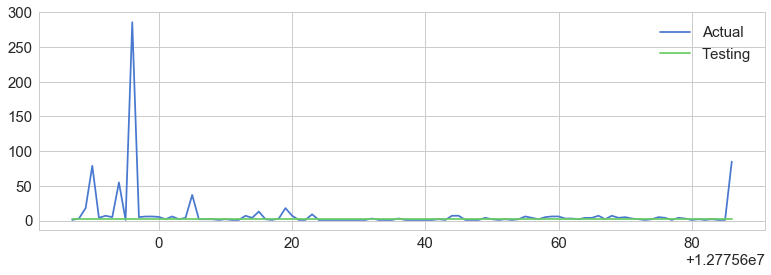

In [23]:
plt.figure(figsize=(13,4))
plt.plot(pd.DataFrame(item_sales_forecast, columns=["unit_sales"], index=store_df.index).unit_sales[-100:], label='Actual')
#plt.plot(pd.DataFrame(trainPredictPlot, columns=["unit_sales"], index=store_df.index).unit_sales, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["unit_sales"], index=store_df.index).unit_sales[-100:], label='Testing')
plt.legend(loc='best')
plt.show()